<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Data-Cleaning" data-toc-modified-id="Data-Cleaning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data Cleaning</a></span></li><li><span><a href="#Data-Split" data-toc-modified-id="Data-Split-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Split</a></span></li></ul></div>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [72]:
import pandas as pd
import numpy as np
import random
import warnings
import time
import datetime
import re
import string
import itertools
import pickle
import joblib
import nltk
import csv

from nltk.corpus import stopwords, wordnet
stop = set(stopwords.words('english'))
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from collections import Counter, defaultdict

import tensorflow as tf
import keras
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Concatenate, Conv2D, Flatten, Dense, Embedding, LSTM
from keras.models import Model
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from keras.regularizers import l2
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.layers import Input, Dense, Flatten, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Add, Conv2D

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv('tweets.csv', encoding='utf-8', error_bad_lines=False, sep=',')
df.drop(['keyword', 'location', 'id'], axis=1, inplace=True)
display(df.sample(5))

,text,target
4532,The world is drowning in debt https://t.co/MO5...,0
4298,2012 Carbon Tax Cost = $4.4b/yr Cost of: 2017-...,0
322,Over the weekend I drove through some of the b...,0
1714,"I mean, there's directness though. Like, the t...",0
3512,Explained: What are CRZ rules which the demoli...,0


In [7]:
df.shape

(11370, 2)

In [8]:
df['target'].value_counts()

0    9256
1    2114
Name: target, dtype: int64

## Data Cleaning

In [9]:
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)

def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

df['clean_text'] = df['text'].apply(lambda x: remove_url(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_emoji(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_html(str(x)))
df['clean_text'] = df['clean_text'].apply(lambda x: remove_punct(str(x)))
df['clean_text'] = df['clean_text'].apply(word_tokenize)
df['clean_text'] = df['clean_text'].apply(lambda x: [word.lower() for word in x])
df['clean_text'] = df['clean_text'].apply(lambda x: [word for word in x if word not in stop])
df['clean_text'] = df['clean_text'].apply(nltk.tag.pos_tag)

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
df['clean_text'] = df['clean_text'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])
wnl = WordNetLemmatizer()
df['clean_text'] = df['clean_text'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])
df['clean_text'] = df['clean_text'].apply(
    lambda x: [word for word in x if word not in stop])
df['clean_text'] = [' '.join(map(str, l)) for l in df['clean_text']]

In [10]:
display(df.sample(2))

,text,target,clean_text
5325,"Before June 2019, there are about 60ppl suicid...",1,june 2019 60ppl suicide month regularly june f...
393,army privilege is being able to call an album ...,0,army privilege able call album sell 4m copy fl...


In [ ]:
# df.to_csv('tweets_processed.csv')

## Data Preparation

In [81]:
disaster_initial = list(df[df['target'] == 1]['clean_text'])
non_disaster_initial = list(df[df['target'] == 0]['clean_text'])

disaster = disaster_initial[:1000]
non_disaster = non_disaster_initial[:1000]

# Creating pairs of data for siamese training => labels for identity loss and class for disaster or non disaster
df2 = pd.DataFrame(columns=['Anchor', 'Positive', 'Negative', 'label', 'class'])

for data in disaster:
  a = data
  p = random.choice(disaster)
  n = random.choice(non_disaster)

  df2.loc[len(df2)] = [a, p, n, 1, 1]


for data in non_disaster:
  a = data
  p = random.choice(non_disaster)
  n = random.choice(disaster)
  
  df2.loc[len(df2)] = [a, p, n, 1, 0]

In [82]:
df2.shape

(2000, 5)

In [83]:
display(df2.sample(5))

,Anchor,Positive,Negative,label,class
974,malaysia master winner suffer cut wholebody br...,become lose himalayan blizzard 4000 meter save...,feel turn 20pg paper bioterrorism civilliberti...,1,1
522,unian info ukrainian plane 737 crash kill vict...,inferno black friday 1939 71 death 3700 buildi...,blizzard push world warcraft future vision n ’...,1,1
813,m24 earthquake report geonetnz 10 km northwest...,lightning taal volcano phillipines volcano has...,apocalypse,1,1
561,volcano erupts philippines taaleruption2020 al...,6alarm fire boundbrook newjersey sun massive f...,ask prayer daughter please take think flu inte...,1,1
729,deeply sadden witness devastation people wildl...,m3 northbound j12 pitmore j11 shawford outside...,1st bias ready attack,1,1


## Data Split

In [84]:
X, X_test, y, y_test = train_test_split(df2[['Anchor', 'Positive', 'Negative']], df2[['label', 'class']], test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X[['Anchor', 'Positive', 'Negative']], y[['label', 'class']], test_size=0.2, random_state=0)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(1280, 3) (320, 3) (400, 3) (1280, 2) (320, 2) (400, 2)


In [85]:
X_train['text'] = X_train[['Anchor', 'Positive', 'Negative']].apply(lambda x: str(x[0])+" "+str(x[1])+" "+str(x[2]), axis=1)

## Glove Embeddings

In [86]:
t = Tokenizer()
t.fit_on_texts(X_train['text'].values)

X_train['Anchor'] = X_train['Anchor'].astype(str)
X_train['Positive'] = X_train['Positive'].astype(str)
X_train['Negative'] = X_train['Negative'].astype(str)
X_val['Anchor'] = X_val['Anchor'].astype(str)
X_val['Positive'] = X_val['Positive'].astype(str)
X_val['Negative'] = X_val['Negative'].astype(str)
X_test['Anchor'] = X_test['Anchor'].astype(str)
X_test['Positive'] = X_test['Positive'].astype(str)
X_test['Negative'] = X_test['Negative'].astype(str)

train_q1_seq = t.texts_to_sequences(X_train['Anchor'].values)
train_q2_seq = t.texts_to_sequences(X_train['Positive'].values)
train_q3_seq = t.texts_to_sequences(X_train['Negative'].values)
val_q1_seq = t.texts_to_sequences(X_val['Anchor'].values)
val_q2_seq = t.texts_to_sequences(X_val['Positive'].values)
val_q3_seq = t.texts_to_sequences(X_val['Negative'].values)
test_q1_seq = t.texts_to_sequences(X_test['Anchor'].values)
test_q2_seq = t.texts_to_sequences(X_test['Positive'].values)
test_q3_seq = t.texts_to_sequences(X_test['Negative'].values)

max_len = 200
train_q1_seq = pad_sequences(train_q1_seq, maxlen=max_len, padding='post')
train_q2_seq = pad_sequences(train_q2_seq, maxlen=max_len, padding='post')
train_q3_seq = pad_sequences(train_q3_seq, maxlen=max_len, padding='post')
val_q1_seq = pad_sequences(val_q1_seq, maxlen=max_len, padding='post')
val_q2_seq = pad_sequences(val_q2_seq, maxlen=max_len, padding='post')
val_q3_seq = pad_sequences(val_q3_seq, maxlen=max_len, padding='post')
test_q1_seq = pad_sequences(test_q1_seq, maxlen=max_len, padding='post')
test_q2_seq = pad_sequences(test_q2_seq, maxlen=max_len, padding='post')
test_q3_seq = pad_sequences(test_q3_seq, maxlen=max_len, padding='post')

In [87]:
#https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html
embeddings_index = {}
f = open('drive/My Drive/Glove/glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [88]:
not_present_list = []
vocab_size = len(t.word_index) + 1
print('Loaded %s word vectors.' % len(embeddings_index))
embedding_matrix = np.zeros((vocab_size, len(embeddings_index['no'])))
for word, i in t.word_index.items():
    if word in embeddings_index.keys():
        embedding_vector = embeddings_index.get(word)
    else:
        not_present_list.append(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.zeros(300)

Loaded 400000 word vectors.


In [89]:
print(embedding_matrix.shape)

(6035, 300)


## Siamese Model

In [90]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

In [91]:
def embedding_model():

  network = Sequential()
  network.add(Embedding(name="synopsis_embedd",input_dim =len(t.word_index)+1, 
                       output_dim=len(embeddings_index['no']),weights=[embedding_matrix], 
                       input_length=train_q1_seq.shape[1],trainable=False))
  network.add(LSTM(64,return_sequences=True, activation="relu"))
  network.add(Flatten())
  network.add(Dense(128, activation='relu',
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))
  
  network.add(Dense(2, activation=None,
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='he_uniform'))
  
  #Force the encoding to live on the d-dimentional hypershpere
  # network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))

  return network


def build_network(base_model):

  input_1 = Input(shape=(train_q1_seq.shape[1],))
  input_2 = Input(shape=(train_q2_seq.shape[1],))
  input_3 = Input(shape=(train_q3_seq.shape[1],))

  A = base_model(input_1)
  P = base_model(input_2)
  N = base_model(input_3)

  loss = Lambda(triplet_loss)([A, P, N])
  model = Model(inputs = [input_1, input_2, input_3], outputs = loss)
  model.compile(loss = identity_loss, optimizer = Adam(0.001))
  return model

In [92]:
base_model = embedding_model()
model = build_network(base_model)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 2)            3542726     input_18[0][0]                   
                                                                 input_19[0][0]            

In [93]:
y_train_label = np.asarray(y_train['label']).astype('float32')
y_val_label = np.asarray(y_val['label']).astype('float32')
y_test_label = np.asarray(y_test['label']).astype('float32')

y_train_class = np.asarray(y_train['class']).astype('float32')
y_val_class = np.asarray(y_val['class']).astype('float32')
y_test_class = np.asarray(y_test['class']).astype('float32')

In [94]:
history = model.fit([train_q1_seq,train_q2_seq, train_q3_seq],y_train_label.reshape(-1,1), epochs = 5, 
          batch_size=64,validation_data=([val_q1_seq, val_q2_seq, val_q3_seq],y_val_label.reshape(-1,1)))

Epoch 1/5
20/20 [==============================] - 24s 955ms/step - loss: 0.3408 - val_loss: 0.1577
Epoch 2/5
20/20 [==============================] - 17s 871ms/step - loss: 0.1185 - val_loss: 0.1308
Epoch 3/5
20/20 [==============================] - 17s 848ms/step - loss: 0.0675 - val_loss: 0.1289
Epoch 4/5
20/20 [==============================] - 17s 843ms/step - loss: 0.0461 - val_loss: 0.1216
Epoch 5/5
20/20 [==============================] - 17s 843ms/step - loss: 0.0322 - val_loss: 0.1511


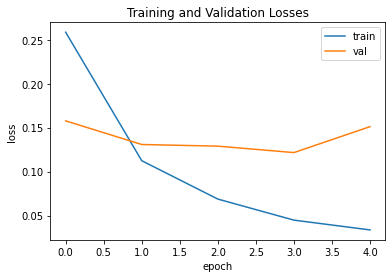

In [95]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Losses',size = 12)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [96]:
# Save model for further use
# serialize model to JSON
model_json = model.to_json()
with open("siamesemodel-triplet-loss.json", "w") as json_file:
    json_file.write(model_json)
#serialize weights to HDF5
model.save_weights("siamesemodel-triplet-loss.h5")
print("Saved model to disk")

# load json and create model
# json_file = open('siamesemodel-triplet-loss.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)
# # load weights into new model
# loaded_model.load_weights("siamesemodel-triplet-loss.h5")
# print("Loaded model from disk")

Saved model to disk


## Evaluation

In [97]:
X_train_eval = base_model.predict(train_q1_seq)
X_test_eval = base_model.predict(test_q1_seq)

# TSNE - dimensionality reduction for data visualization
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_eval)

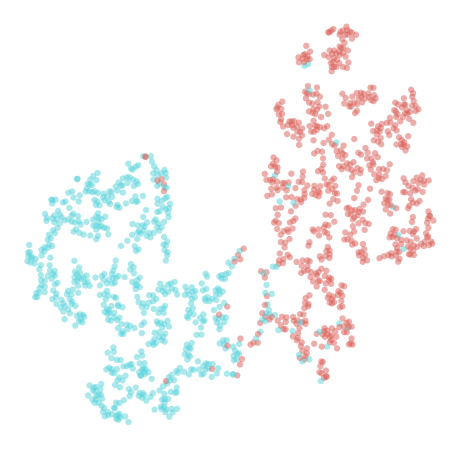

In [98]:
def scatter(x, labels, subtitle=None):
    # Create a scatter plot of all the 
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 2))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

scatter(train_tsne_embeds, y_train_class)

In [108]:
# classifier that computes the class of a specific embedding for prediction purposes
classifier_input = Input(shape=(2,))
classifier_output = Dense(2, activation='softmax')(classifier_input)
classifier_model = Model(classifier_input, classifier_output)

# onehot encoding vectors to 2 classes
Y_train_onehot = np_utils.to_categorical(y_train_class, 2)
Y_test_onehot = np_utils.to_categorical(y_test_class, 2)

classifier_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
classifier_model.fit(X_train_eval,Y_train_onehot, validation_data=(X_test_eval, Y_test_onehot),epochs=5)

Epoch 1/5
40/40 [==============================] - 1s 8ms/step - loss: 0.8896 - accuracy: 0.3246 - val_loss: 0.8359 - val_accuracy: 0.4000
Epoch 2/5
40/40 [==============================] - 0s 2ms/step - loss: 0.8835 - accuracy: 0.2942 - val_loss: 0.8190 - val_accuracy: 0.4025
Epoch 3/5
40/40 [==============================] - 0s 2ms/step - loss: 0.8649 - accuracy: 0.2931 - val_loss: 0.8036 - val_accuracy: 0.4150
Epoch 4/5
40/40 [==============================] - 0s 2ms/step - loss: 0.8463 - accuracy: 0.3315 - val_loss: 0.7886 - val_accuracy: 0.4325
Epoch 5/5
40/40 [==============================] - 0s 2ms/step - loss: 0.8392 - accuracy: 0.3447 - val_loss: 0.7749 - val_accuracy: 0.4450


## Prediction

In [117]:
input = X_test_eval[:10]
prediction = classifier_model.predict(input)
print(prediction)

[[0.57734007 0.42265993]
 [0.5099686  0.49003142]
 [0.663019   0.33698094]
 [0.5294936  0.4705064 ]
 [0.6796928  0.32030725]
 [0.41265553 0.5873444 ]
 [0.45711055 0.5428895 ]
 [0.4050156  0.5949844 ]
 [0.4821242  0.51787573]
 [0.5516306  0.44836932]]
